In [9]:
import numpy as np
X_detrended = np.load("X_demo.npy", allow_pickle=True)
r_peaks_all_patients = np.load("r_peaks_demo.npy", allow_pickle=True)

sampling_rate = 500



In [10]:
import matplotlib.pyplot as plt

# 以下是畫圖的函式
def plot_ecg_with_q_s_and_qrs_region(patient_index, lead_index):
    ecg_signal = X_detrended[patient_index, :, lead_index]
    r_peaks = r_peaks_all_patients[patient_index, lead_index]

    interval = int(0.060 * sampling_rate)
    qrs_regions = [(r - interval, r + interval) for r in r_peaks]

    q_peaks = find_q_peaks_within_region(ecg_signal, r_peaks, qrs_regions)
    s_peaks = find_s_peaks_within_region(ecg_signal, r_peaks, qrs_regions)
    qrs_onsets = find_qrs_onset(ecg_signal, q_peaks)
    qrs_offsets = find_qrs_offset(ecg_signal, s_peaks)

    plt.figure(figsize=(20,10))
    plt.plot(ecg_signal, label='ECG signal')

    for onset, offset in zip(qrs_onsets, qrs_offsets):
        plt.axvspan(onset, offset, color='yellow', alpha=0.5, label='QRS region' if onset == qrs_onsets[0] else None)

    plt.plot(q_peaks, ecg_signal[q_peaks], 'o', color='orange', label='Q peaks')
    plt.plot(s_peaks, ecg_signal[s_peaks], 'o', color='blue', label='S peaks')

    plt.title(f"Patient {patient_index + 1}, Lead {lead_index + 1}")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def compute_slope(signal, idx, window_size):
    if idx + window_size < len(signal):
        return (signal[idx + window_size] - signal[idx]) / window_size
    else:
        return 0

def find_q_peaks_within_region(ecg_signal, r_peaks, qrs_regions, sampling_rate=500):
    q_peaks = []
    for r_pos, (start, end) in zip(r_peaks, qrs_regions):
        qr_region = ecg_signal[start:r_pos]
        q_pos = start + np.argmin(qr_region)
        q_peaks.append(q_pos)
    return np.array(q_peaks)

def find_s_peaks_within_region(ecg_signal, r_peaks, qrs_regions, sampling_rate=500):
    s_peaks = []
    for r_pos, (start, end) in zip(r_peaks, qrs_regions):
        rs_region = ecg_signal[r_pos:end]
        s_pos = r_pos + np.argmin(rs_region)
        s_peaks.append(s_pos)
    return np.array(s_peaks)

def find_qrs_onset(ecg_signal, q_peaks, sampling_rate=500):
    window_size = int(0.02* sampling_rate)
    qrs_onsets = []
    for q_peak in q_peaks:
        min_slope = float('inf')
        onset = q_peak - 1
        for i in range(q_peak - 1, q_peak - window_size, -1):
            if i < 0:
                break
            slope = compute_slope(ecg_signal, i, window_size)
            if slope < min_slope:
                min_slope = slope
                onset = i
        qrs_onsets.append(onset)
    return np.array(qrs_onsets)

def find_qrs_offset(ecg_signal, s_peaks, sampling_rate=500):
    window_size = int(0.02* sampling_rate)
    qrs_offsets = []
    for s_peak in s_peaks:
        min_slope = float('inf')
        offset = s_peak + 1
        for i in range(s_peak + 1, s_peak + window_size):
            if i >= len(ecg_signal):
                break
            slope = compute_slope(ecg_signal, i, window_size)
            if slope < min_slope:
                min_slope = slope
                offset = i
        qrs_offsets.append(offset)
    return np.array(qrs_offsets)


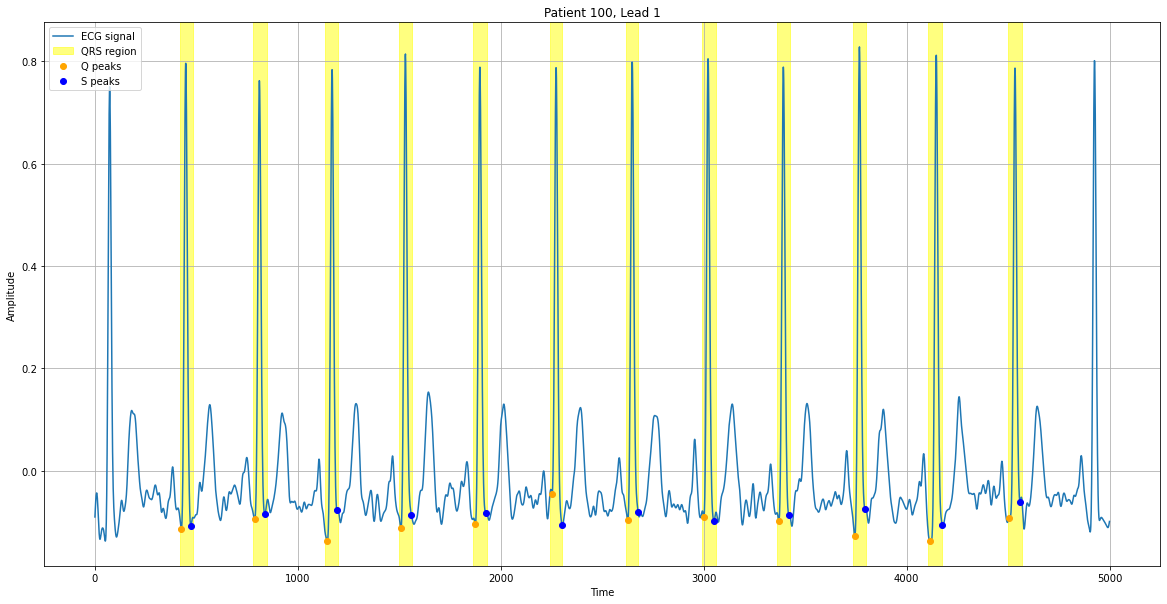

In [11]:
plot_ecg_with_q_s_and_qrs_region(99, 0)

